<a href="https://colab.research.google.com/github/janastadtruckerova/crypto_prediction/blob/main/predikcia_kryptomien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predikcia cien kryptomien**

**Cieľ projektu**

Predpovedať cenu kryptomien

**Import potrebných knižníc**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

**Načítanie dát**

In [2]:
# Načítanie datasetu

crypto_df = pd.read_csv("coin_Aave.csv")

# Zobrazenie prvých riadkov
crypto_df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Aave,AAVE,10/5/2020 23:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07
1,2,Aave,AAVE,10/6/2020 23:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07
2,3,Aave,AAVE,10/7/2020 23:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07
3,4,Aave,AAVE,10/8/2020 23:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08
4,5,Aave,AAVE,10/9/2020 23:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08


**Preskúmanie dát**

In [3]:
# Kontrola chýbajúcich hodnôt
print("Missing values:")
print(crypto_df.isnull().sum())



Missing values:
SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64


In [4]:
print(crypto_df.columns)


Index(['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Marketcap'],
      dtype='object')


In [5]:
# Konverzia dátumu
crypto_df['Date'] = pd.to_datetime(crypto_df['Date'])
crypto_df.set_index('Date', inplace=True)

In [6]:
print(crypto_df.dtypes)


SNo            int64
Name          object
Symbol        object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object


**Exploratívna analýza**

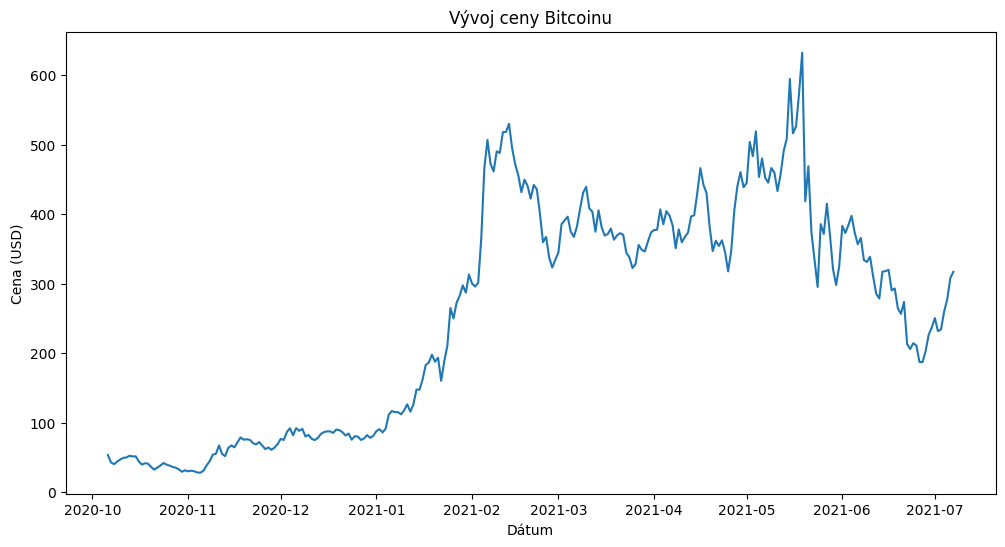

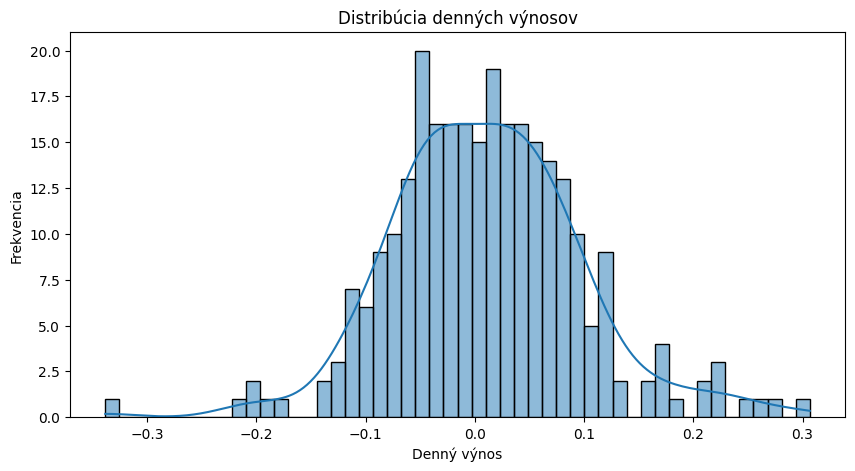

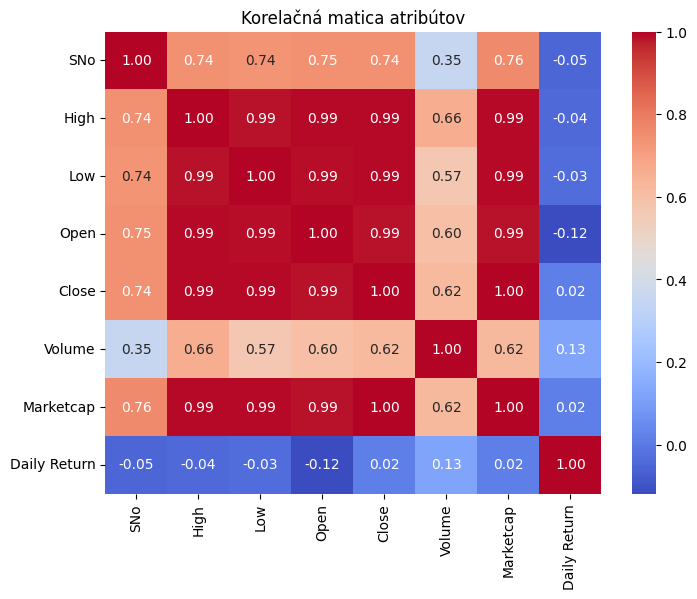

In [7]:
# Vizualizácia historických cien
plt.figure(figsize=(12, 6))
sns.lineplot(data=crypto_df, x=crypto_df.index, y='Close')
plt.title('Vývoj ceny Bitcoinu')
plt.xlabel('Dátum')
plt.ylabel('Cena (USD)')
plt.show()

# Vypočítanie denného percentuálneho nárastu
crypto_df['Daily Return'] = crypto_df['Close'].pct_change()

# Histogram denných zmien
plt.figure(figsize=(10, 5))
sns.histplot(crypto_df['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Distribúcia denných výnosov')
plt.xlabel('Denný výnos')
plt.ylabel('Frekvencia')
plt.show()


# Výber iba číselných stĺpcov
crypto_numeric = crypto_df.select_dtypes(include=['number'])

# Korelačná matica
plt.figure(figsize=(8, 6))
sns.heatmap(crypto_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelačná matica atribútov')
plt.show()


 **Rozdelenie datasetu na tréningovú a testovaciu množinu**

In [8]:
from sklearn.model_selection import train_test_split
# Odstránenie riadkov s NaN hodnotami
crypto_df = crypto_df.dropna()

# Výber číselných stĺpcov (bez textových)
crypto_numeric = crypto_df.select_dtypes(include=['number'])

# Definovanie X (vstupné atribúty) a y (cieľová premenná)
X = crypto_numeric.drop(columns=['Close'])  # Nezávislé premenné
y = crypto_numeric['Close']  # Predikujeme cenu uzatvorenia

# Rozdelenie dát na tréningovú a testovaciu množinu (80% tréning, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
print(X_train.isnull().sum())  # Počet chýbajúcich hodnôt v každom stĺpci


SNo             0
High            0
Low             0
Open            0
Volume          0
Marketcap       0
Daily Return    0
dtype: int64


In [13]:
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.loc[X_train.index]  # Zarovnáme y_train
y_test = y_test.loc[X_test.index]  # Zarovnáme y_test


**Tréning modelov**

In [14]:
# Tréning lineárnej regresie
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Tréning Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Tréning XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

**Vyhodnotenie modelov**

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5  # Ručne vypočítané RMSE
    r2 = r2_score(y_true, y_pred)

    print(f'{model_name} - MSE: {mse}')
    print(f'{model_name} - RMSE: {rmse}')
    print(f'{model_name} - R^2: {r2}\n')

evaluate_model(y_test, y_pred_lr, 'Linear Regression')
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_xgb, 'XGBoost')


Linear Regression - MSE: 24.725099995651536
Linear Regression - RMSE: 4.972434011191253
Linear Regression - R^2: 0.9989961923000799

Random Forest - MSE: 19.61639916013794
Random Forest - RMSE: 4.429040433337445
Random Forest - R^2: 0.9992035990744176

XGBoost - MSE: 26.296790525175453
XGBoost - RMSE: 5.128039637636926
XGBoost - R^2: 0.9989323836580236



**Viazualizácie**

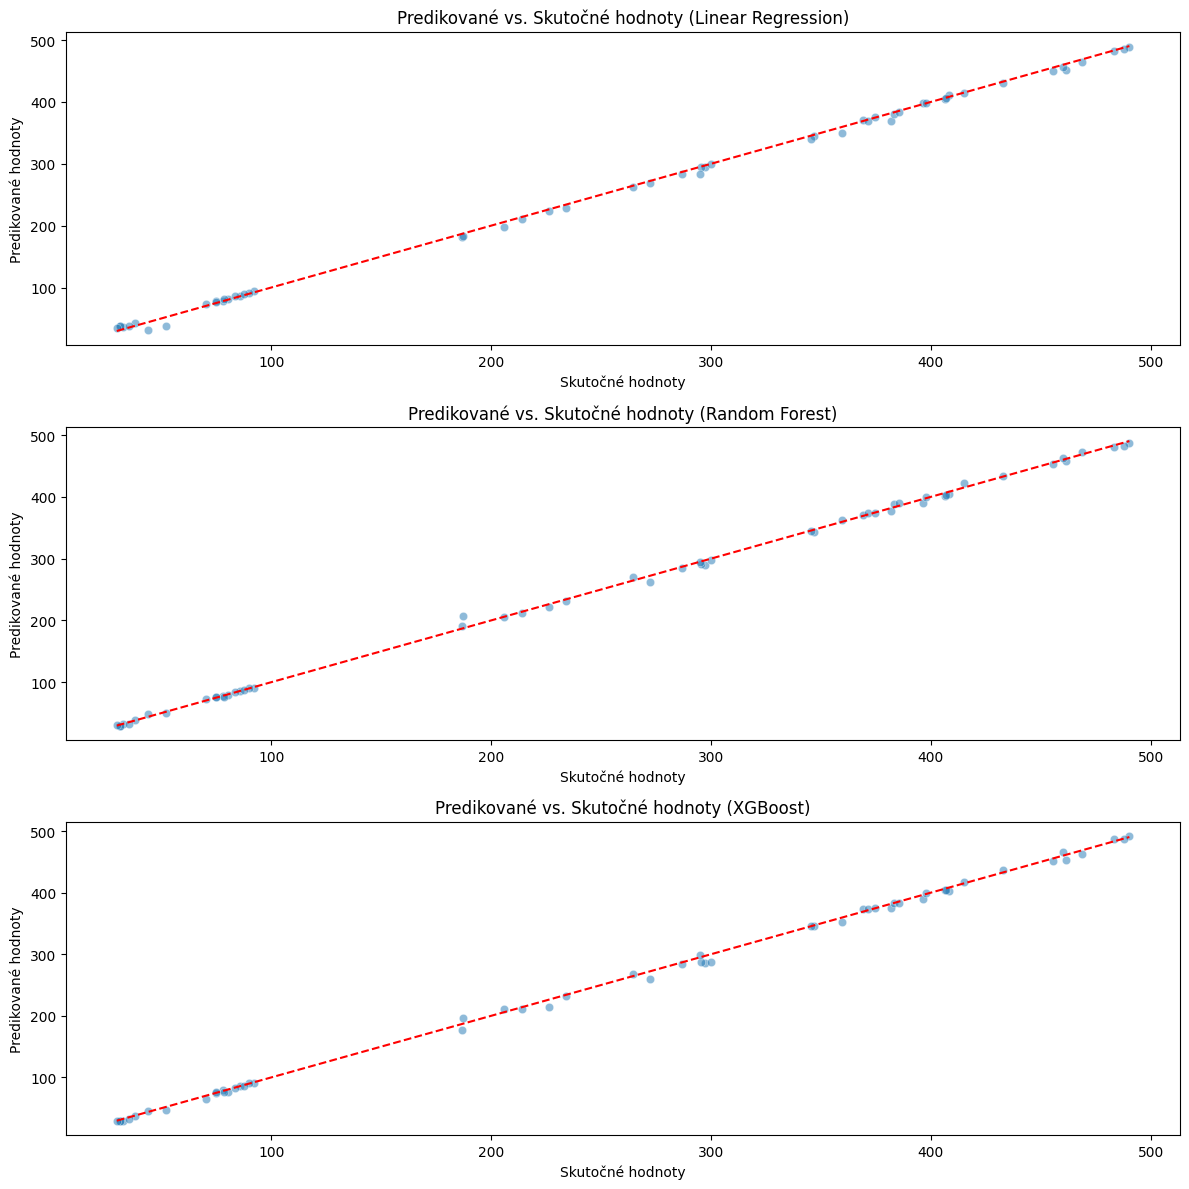

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vytvorenie samostatných grafov pre každý model
models = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

plt.figure(figsize=(12, 12))

for i, (model_name, y_pred) in enumerate(models.items(), 1):
    plt.subplot(3, 1, i)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')  # Ideálna línia
    plt.xlabel("Skutočné hodnoty")
    plt.ylabel("Predikované hodnoty")
    plt.title(f"Predikované vs. Skutočné hodnoty ({model_name})")

plt.tight_layout()
plt.show()



**Analýza citlivosti modelov**

<Figure size 1200x600 with 0 Axes>

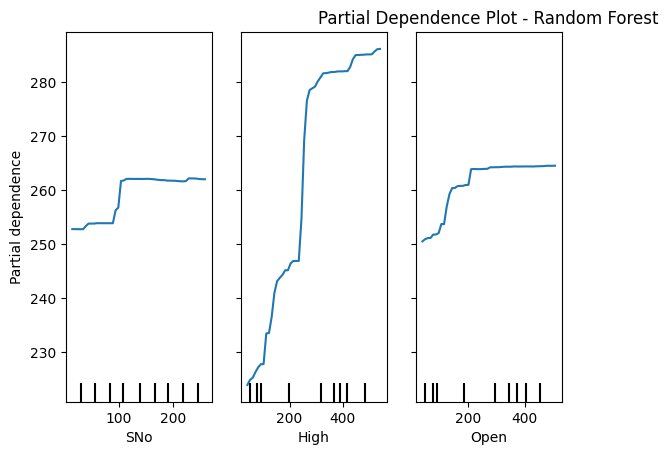

In [17]:
from sklearn.inspection import PartialDependenceDisplay

# Pre Random Forest
plt.figure(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[0, 1, 3], feature_names=X.columns, grid_resolution=50)
plt.title("Partial Dependence Plot - Random Forest")
plt.show()



<Figure size 1200x600 with 0 Axes>

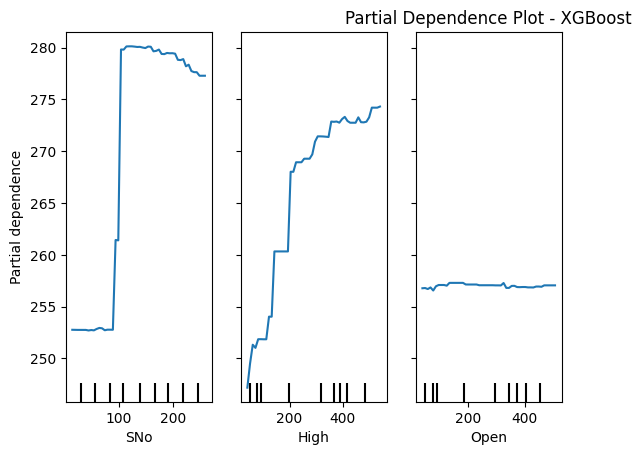

In [18]:
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb

# Pre XGBoost
plt.figure(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0, 1, 3], feature_names=X.columns, grid_resolution=50)
plt.title("Partial Dependence Plot - XGBoost")
plt.show()
